In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [15]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
filepath="C:/Users/CS_Knit_tinK_SC/Documents/GitHub/HW_7_TS_ML_Inputs-U10/Resources/yen.csv"
yen_futures = pd.read_csv(filepath, index_col="Date", infer_datetime_format=True, parse_dates=True)

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [16]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [17]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns.rename(columns={'Settle':'Returns'}, inplace=True)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Returns
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


### Lagged Returns 

In [18]:
# Create a lagged return using the shift function
returns['Lagged_Return'] = returns.shift()  # creates a lag of 1, for autoregressive factor
returns.tail()

,Returns,Lagged_Return
Date,,
2019-10-09,-0.410601,0.170931
2019-10-10,-0.369458,-0.410601
2019-10-11,-0.564304,-0.369458
2019-10-14,0.151335,-0.564304
2019-10-15,-0.469509,0.151335


### Train Test Split

In [26]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = returns.loc[:"2017"].dropna()
test = returns.loc["2018":"2019"]

In [27]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()

y_train = train["Returns"]
y_test = test["Returns"]

In [28]:
X_train

,Lagged_Return
Date,
1990-01-04,0.584197
1990-01-05,1.756933
1990-01-08,-0.827626
1990-01-09,0.129496
1990-01-10,-0.632275
...,...
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230


# Linear Regression Model

In [29]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

X = X_train.Lagged_Return.values.reshape(-1, 1)
Y = train["Returns"]

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):

model = LinearRegression()

In [30]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):

model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [34]:
# Make a prediction of "y" values using just the test dataset
X2 = X_test.Lagged_Return.values.reshape(-1, 1)
predicted_y_values = model.predict(X2)
predicted_y_values

array([ 3.81487856e-03,  3.04552923e-03,  8.75886643e-03,  8.46722705e-03,
        9.96422847e-03,  5.54507405e-03,  2.07350579e-03, -6.13941602e-03,
        3.72827035e-03,  6.02753682e-03, -9.69420826e-04,  1.39716758e-02,
        5.26261632e-03,  2.44191635e-03,  1.00698798e-02, -2.03980189e-04,
       -6.12603448e-03,  9.90095892e-03, -1.04195295e-03,  8.85239423e-03,
        4.58784211e-03,  9.48891960e-03,  9.32567920e-03,  1.43791356e-02,
        7.70010848e-04,  2.83229073e-03,  6.89934081e-03,  1.15915331e-03,
        3.20292363e-03,  7.35495457e-03, -3.35964887e-03,  1.51559282e-04,
       -1.80127111e-03,  6.82381188e-03,  1.57890706e-02,  1.12677326e-02,
       -5.00112268e-03,  7.22225932e-03,  8.01600611e-03,  1.11955991e-02,
       -1.20485968e-03,  2.35541558e-03, -7.88644420e-04,  1.28707271e-02,
        6.37309179e-03,  4.62515299e-03,  8.11823975e-03,  1.15059323e-02,
        2.23588159e-03,  8.68890086e-03,  2.80746187e-03,  6.31681658e-03,
        4.68024509e-03,  

In [35]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predicted_y_values
Results.head()

,Returns,Predicted Return
Date,,
2018-01-02,0.297285,0.003815
2018-01-03,-0.240479,0.003046
2018-01-04,-0.213028,0.008759
2018-01-05,-0.353933,0.008467
2018-01-08,0.062017,0.009964


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001BDEEE2A288>,
      dtype=object)

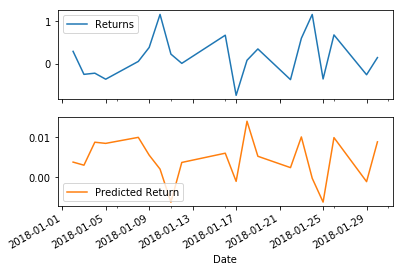

In [36]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [33]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# Mean Squared Error
mse = mean_squared_error(y_train, predicted_y_values)
print(mse)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
rmse

0.4983495489863568


0.7059387714146014

# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [ ]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!

# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

# Conclusions

YOUR CONCLUSIONS HERE!